# RNN vs CNN

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers, utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Data

- we load the train and test subsets of the 20 Newsgroups data set from sklearn datasets
- we remove the headers, footers and qoutes from the news article when loading data sets, using 321 for random_state

- in order to get faster execution times for this practical we will work on a partial data set with only 5 categories out of the 20 available in the data set: 
    - rec.sport.hockey
    - talk.politics.mideast
    - soc.religion.christian
    - comp.graphics
    - sci.med

In [2]:
# select couple of the categories in 20newsgroups
categories = ['rec.sport.hockey', 'talk.politics.mideast', 'soc.religion.christian', 'comp.graphics', 'sci.med']

# fetch the training set
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, shuffle=True, random_state=321)

# fetch the test set
twenty_test = fetch_20newsgroups(subset='test', remove=('headers','footers', 'quotes'), categories=categories, shuffle=True, random_state=321)

# convert to a dataframe
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'label'])

df_test = pd.DataFrame(list(zip(twenty_test.data, twenty_test.target)), columns=['text', 'label'])

# tokenizer from keras
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text.values)
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)
vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index for sequence padding

# pad sequence
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Encode the list of newsgroups into categorical integer values
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
y_train = utils.to_categorical(y)
y = lb.transform(df_test.label.values)
y_test = utils.to_categorical(y)

In [3]:
plt.style.use('ggplot')
def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        # we can add a validation set in our fit function with nn
        val_acc = history.history['val_accuracy'] 
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

## Recurrent neural networks

A recurrent neural network (RNN) is a natural generalization of feed-forward neural networks to sequence data such as text. In contrast to a feed-forward neural network, however, it accepts a new input at every time step (layer). Long-short term memory (LSTM) networks are a variant of RNNs. The LSTM introduces mechanisms to decide what should be remembered and what should be forgotten in learning from text documents.

We now build a neural network model with an LSTM layer of 100 units. 
the first layer should be an embedding layer, then the LSTM layer, a Dense layer, and the output Dense layer for the 5 news categories. 

In [4]:
embedding_dim = 100
model = Sequential()

#embedding layer
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

#LSTM layer
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))

#Dense layer
model.add(layers.Dense(10, activation='relu'))

#Output Dense layer
model.add(layers.Dense(5, activation='softmax'))

#compile the model and print the summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3811100   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 3,892,565
Trainable params: 3,892,565
Non-trainable params: 0
_________________________________________________________________


The first layer is the Embedded layer that uses 100 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons!). Finally, because this is a classification problem we use a Dense output layer with 5 neurons and a softmax activation function to make 0 or 1 predictions for the five classes.

Now, we fit the model in 5 epochs.

In [5]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

And we evaluate the accuracy of training and test data using your model and plot the history of fit

Training Accuracy: 0.6658
Testing Accuracy:  0.5552


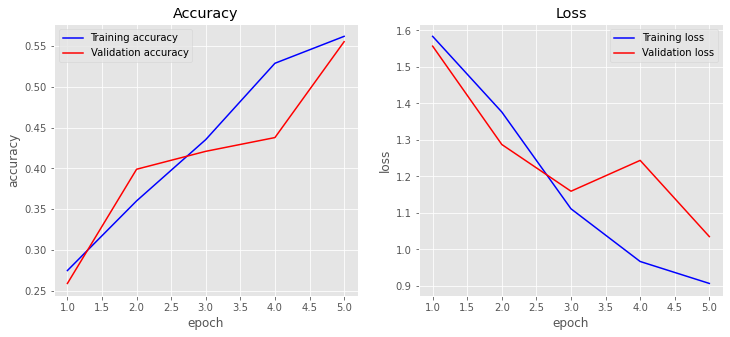

In [6]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Now, we train the model with 20 epochs

Training Accuracy: 0.8603
Testing Accuracy:  0.7227


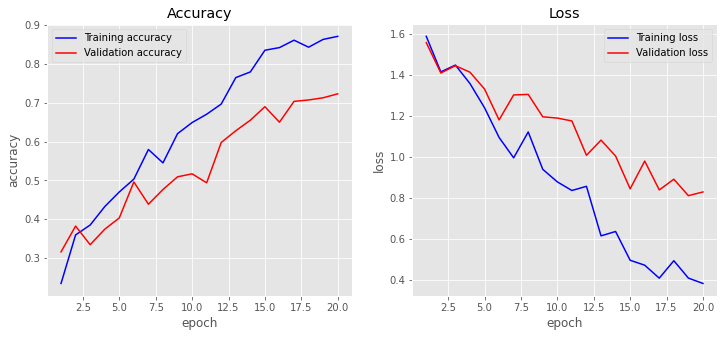

In [7]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

## Convolutional neural networks

Convolutional neural networks or also called convnets are one of the most exciting developments in machine learning in recent years. They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same.

We build a neural network model with an convolution layer (Conv1D) of 125 units and window size of 5. As before, the first layer should be an embedding layer, a Dense layer, and the output Dense layer for the 5 news categories. 

In [8]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3811100   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 3,876,573
Trainable params: 3,876,573
Non-trainable params: 0
_________________________________________________________________


We fit the model with 5 epochs and test the accuracy

Training Accuracy: 0.9660
Testing Accuracy:  0.8258


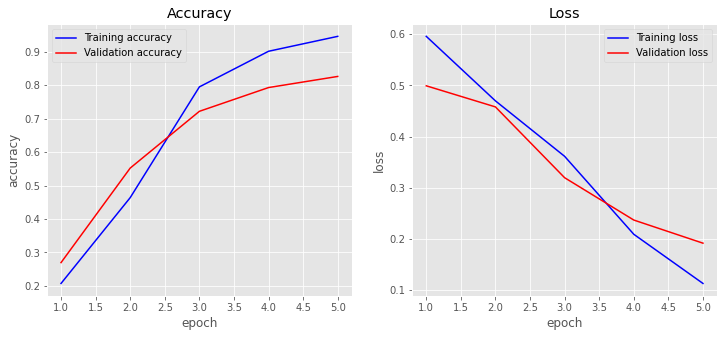

In [9]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Now, we do the same as before and test the model with more epochs

Training Accuracy: 0.9803
Testing Accuracy:  0.8519


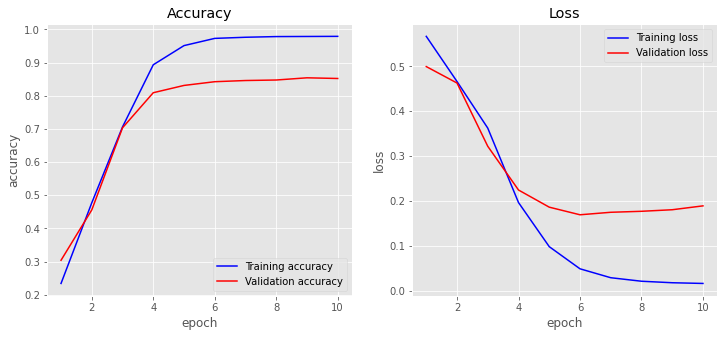

In [10]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

## Hyperparameter Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization. **Hyperparameters** are parameters that are chosen by the algorithm designer and have to be tested and tuned.

One popular method for hyperparameter optimization is **grid search**. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way is **random search**, which you’ll see in action here, simply takes random combinations of parameters.

Now, we will write a function for creating your cnn-based model which has the number of filters, kernel size, embedding size, and maxlen as input arguments. We will name this function `create_model`. 

In [11]:
def create_model(num_filters, kernel_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

We store all the hyperparameters of our model into a dictionary `param_grid`

In [12]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  embedding_dim=[50, 100],
                  maxlen=[100, 200])

In [13]:
model = KerasClassifier(build_fn=create_model,
                        epochs = 10,
                        batch_size=64,
                        verbose=True)

Now, we call the RandomizedSearchCV function and pass the `param_grid` for the hyperparamters

In [14]:
grid = RandomizedSearchCV(estimator=model,
                          param_distributions=param_grid,
                          cv=5,
                          n_jobs=-1,
                          verbose=1,
                          n_iter=2)

In [15]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   55.2s remaining:   36.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


Epoch 1/10
46/46 [==============================] - 1s 22ms/step - loss: 0.5906 - accuracy: 0.2023
Epoch 2/10
46/46 [==============================] - 1s 21ms/step - loss: 0.4935 - accuracy: 0.2829
Epoch 3/10
46/46 [==============================] - 1s 21ms/step - loss: 0.4680 - accuracy: 0.3339
Epoch 4/10
46/46 [==============================] - 1s 21ms/step - loss: 0.4141 - accuracy: 0.4862
Epoch 5/10
46/46 [==============================] - 1s 21ms/step - loss: 0.3259 - accuracy: 0.6273
Epoch 6/10
46/46 [==============================] - 1s 20ms/step - loss: 0.2148 - accuracy: 0.8725
Epoch 7/10
46/46 [==============================] - 1s 22ms/step - loss: 0.1148 - accuracy: 0.9561
Epoch 8/10
46/46 [==============================] - 1s 22ms/step - loss: 0.0584 - accuracy: 0.9742
Epoch 9/10
46/46 [==============================] - 1s 22ms/step - loss: 0.0353 - accuracy: 0.9782
Epoch 10/10
46/46 [==============================] - 1s 20ms/step - loss: 0.0253 - accuracy: 0.9776


In [16]:
grid_result.best_params_

{'num_filters': 64, 'maxlen': 200, 'kernel_size': 7, 'embedding_dim': 50}

In [17]:
test_accuracy = grid.score(X_test, y_test)
test_accuracy

31/31 [==============================] - 0s 4ms/step - loss: 0.2080 - accuracy: 0.8427


0.8426966071128845

Overall, based on the accuracy and loss you've reported, it seems like your model is performing quite well with the optimized hyperparameters.

In [18]:
best_params = {'num_filters': 32, 'maxlen': 200, 'kernel_size': 5, 'embedding_dim': 100}


model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          3811100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 32)           16032     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
Total params: 3,827,517
Trainable params: 3,827,517
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9803
Testing Accuracy:  0.8504


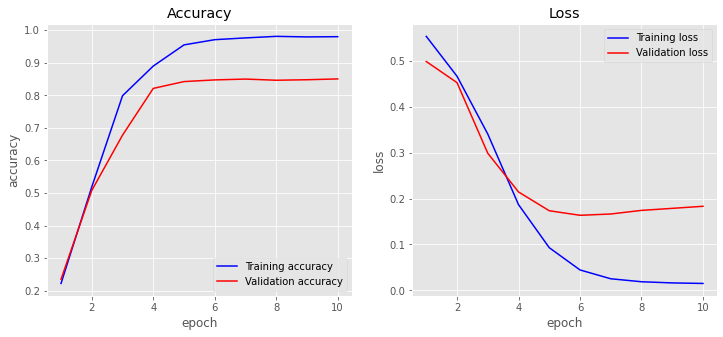

In [19]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)